In [1]:
import json
import pandas as pd
import os
import numpy as np

In [156]:
#Location of each resource type
#['category'][0]['coding'][0]['display'], Careplan

#['type'][0]['text'], encounter
#['vaccineCode']['coding'][0]['display'], immunization
#['medicationCodeableConcept']['coding'][0]['display'], medication
#['type']['coding'][0]['display']
#['id'], patient
#['code']['coding'][0]['display'], Procedure
#['code']['coding'][0]['display'], condition
#['code']['coding'][0]['display'], observation
#['code']['coding'][0]['display'], diagonstic report

#['vaccineCode']['coding'][0]['display'], immunization
#['medicationCodeableConcept']['coding'][0]['display'], medication


### Change the SYNTHEA STU-3 FHIR data to pandas dataframe 

In [159]:
directory = os.fsencode('SYNTHEA/')
encounters,conditions,patient_ids,procedures, observations, dignotstics_reports, immunizations, medication_orders, careplans = ([] for _ in range(9))

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    with open('SYNTHEA/'+filename, "r") as read_file:
        data = json.load(read_file)
        resources = data['entry']
        patient_id = resources[0]['resource']['id']
        patient_ids.append(patient_id)
        patient_encounters,patient_conditions, patient_procedures,patient_observations, patient_diagnostics_reports, patient_immunizations, patient_medication_orders, patient_careplans = (set() for _ in range(8))
   
        for resource in resources:
            resource_type = resource['resource']['resourceType']
            if resource_type =='Encounter':
                patient_encounters.add(resource['resource']['type'][0]['coding'][0]['code'])
            elif resource_type =='Condition':
                patient_conditions.add(resource['resource']['code']['coding'][0]['code'])
            elif resource_type =='Procedure':
                patient_procedures.add(resource['resource']['code']['coding'][0]['code'])  
            elif resource_type =='Observation':
                patient_observations.add(resource['resource']['code']['coding'][0]['code'])
            elif resource_type =='DiagnosticReport':
                patient_diagnostics_reports.add(resource['resource']['code']['coding'][0]['code'])
            elif resource_type == 'Immunization':
                patient_immunizations.add(resource['resource']['vaccineCode']['coding'][0]['code'])
            elif resource_type == 'MedicationOrder':
                patient_medication_orders.add(resource['resource']['medicationCodeableConcept']['coding'][0]['code'])
            elif resource_type == 'CarePlan':
                patient_careplans.add(resource['resource']['category'][0]['coding'][0]['code'])
        encounters.append(','.join(patient_encounters))
        conditions.append(','.join(patient_conditions))
        procedures.append(','.join(patient_procedures))
        observations.append(','.join(patient_observations))
        dignotstics_reports.append(','.join(patient_diagnostics_reports))
        immunizations.append(','.join(patient_immunizations))
        medication_orders.append(','.join(patient_medication_orders))
        careplans.append(','.join(patient_careplans))
        
        
data = {'patient': patient_ids,'Encounter': encounters, 'Condition': conditions, 'Procedure':procedures, 'Observation':observations, 
        'Diagnostics Report':dignotstics_reports, 'Immunization':immunizations, 'Medication Orders':medication_orders, 'Careplan': careplans}
resource_df = pd.DataFrame(data)

In [160]:
resource_df.head()

,patient,Encounter,Condition,Procedure,Observation,Diagnostics Report,Immunization,Medication Orders,Careplan
0,9f59ec59-5116-401b-bcbb-f019a6ca7a4f,"185345009,50849002,183495009,170258001,185349003","44465007,444470001,10509002,359817006,44481400...","305428000,699253003,269911007,428191000124101","55284-4,29463-7,8302-2,39156-5,8331-1",,"140,115,114,62","198405,857005,310965,608680","385691007,91251008,53950000"
1,765382db-8551-4733-8658-d9fc7b0f7ee8,"185349003,185345009","44054006,368581000119106,10509002,15777000,444...","23426006,428191000124101","29463-7,39156-5,2339-0,18262-6,4548-4,49765-1,...","51990-0,57698-3","140,113","860975,608680","698360004,53950000"
2,63927398-3432-4526-9960-0da4359e3be2,"185349003,185345009,170258001","444814009,275272006,43878008","117015009,428191000124101","55284-4,29463-7,8302-2,39156-5,8331-1",,"140,62,114,113","824184,834101",
3,7af203fe-86af-42a9-b6ee-f2c2828ead13,"185349003,185345009","38341003,444814009,40055000",428191000124101,"55284-4,33914-3,18262-6,29463-7,8302-2,39156-5...",57698-3,"140,113",824184,
4,9a0ea485-3bba-457f-bcaa-8cbb8fba34ef,"185349003,185345009,183452005,50849002","44054006,428251008,15777000,444814009,19566200...","80146002,428191000124101","29463-7,39156-5,2339-0,18262-6,4548-4,49765-1,...","51990-0,57698-3","121,140,113",860975,"47387005,698360004"


In [161]:
resource_df.columns

Index(['patient', 'Encounter', 'Condition', 'Procedure', 'Observation',
       'Diagnostics Report', 'Immunization', 'Medication Orders', 'Careplan'],
      dtype='object')

In [162]:
res = resource_df.replace('', np.nan)

In [163]:
res.isnull().sum()

patient                 0
Encounter               1
Condition              47
Procedure             222
Observation             3
Diagnostics Report    312
Immunization          209
Medication Orders      91
Careplan              156
dtype: int64

In [165]:
#drop patients with null values for datasets understudy
res_condition = res.dropna(axis=0, how='any', subset=['Condition','Procedure', 'Medication Orders', 'Observation'])

In [166]:
res_condition.shape

(721, 9)

In [167]:
res_condition.isnull().sum()

patient                 0
Encounter               0
Condition               0
Procedure               0
Observation             0
Diagnostics Report    271
Immunization            2
Medication Orders       0
Careplan               62
dtype: int64

In [168]:
diseases = []
disease_bundled = []
for condition in res_condition['Condition'].values:
    diseases.extend(condition.split(','))
    disease_bundled.append(condition.split(','))

In [169]:
len(diseases)

3298

In [170]:
from collections import Counter

disease_count = Counter(diseases)

In [171]:
disease_count

Counter({'44465007': 74,
         '444470001': 5,
         '10509002': 280,
         '359817006': 7,
         '444814009': 444,
         '195662009': 296,
         '44054006': 30,
         '368581000119106': 13,
         '15777000': 200,
         '38341003': 188,
         '275272006': 5,
         '43878008': 115,
         '40055000': 122,
         '428251008': 33,
         '74400008': 33,
         '422034002': 8,
         '62106007': 43,
         '39848009': 42,
         '410429000': 19,
         '429007001': 19,
         '72892002': 88,
         '398254007': 9,
         '33737001': 12,
         '195967001': 24,
         '239873007': 32,
         '230690007': 34,
         '65363002': 101,
         '367498001': 11,
         '233678006': 23,
         '233604007': 4,
         '26929004': 17,
         '64859006': 48,
         '423121009': 7,
         '254637007': 10,
         '162573006': 11,
         '82423001': 5,
         '15724005': 1,
         '284549007': 18,
         '403190006': 19

<BarContainer object of 112 artists>

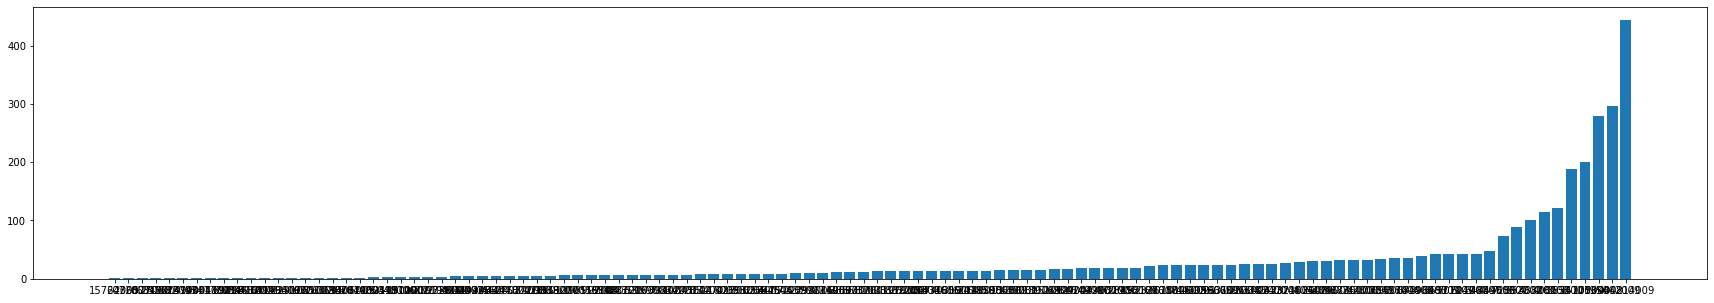

In [172]:
import matplotlib.pyplot as plt
disease_count_sorted = dict(sorted(disease_count.items(), key= lambda item: item[1]))
cases = list(disease_count_sorted.keys())
count = list(disease_count_sorted.values())
fig = plt.figure(figsize=(30,5))
plt.bar(cases, count)

In [173]:
disease_count_sorted

{'15724005': 1,
 '6072007': 1,
 '236077008': 1,
 '86849004': 1,
 '287182007': 1,
 '262574004': 1,
 '157141000119108': 1,
 '95417003': 1,
 '97331000119101': 1,
 '69896004': 1,
 '254632001': 1,
 '67841000119103': 1,
 '609496007': 1,
 '196416002': 1,
 '230265002': 2,
 '93761005': 2,
 '110030002': 2,
 '363406005': 2,
 '37849005': 2,
 '90781000119102': 3,
 '425048006': 3,
 '239872002': 3,
 '124171000119105': 3,
 '1501000119109': 3,
 '239720000': 3,
 '233604007': 4,
 '403192003': 4,
 '444448004': 4,
 '90560007': 4,
 '444470001': 5,
 '275272006': 5,
 '82423001': 5,
 '109838007': 5,
 '197927001': 6,
 '1551000119108': 6,
 '198992004': 6,
 '55680006': 6,
 '359817006': 7,
 '423121009': 7,
 '35999006': 7,
 '307731004': 7,
 '30832001': 7,
 '40275004': 7,
 '422034002': 8,
 '85116003': 8,
 '127013003': 8,
 '47693006': 8,
 '398254007': 9,
 '62564004': 9,
 '84757009': 9,
 '254637007': 10,
 '22298006': 10,
 '399211009': 10,
 '367498001': 11,
 '162573006': 11,
 '33737001': 12,
 '368581000119106': 13,
 '7

###  Choose conditions for study

In [174]:
candidates = list(disease_count_sorted.keys())[-5:]
print(candidates)

['38341003', '15777000', '10509002', '195662009', '444814009']


In [175]:
from collections import defaultdict
case_intersection = defaultdict(lambda: [])
for case1 in candidates:
    for case2 in candidates:
        count = 0
        for case in disease_gross:
            if case1 in case and case2 in case:
                count+=1
        case_intersection[case1].append(count)
                
                
    

In [180]:
#Check comorbidity between candidates for study
case_intersection_df = pd.DataFrame(case_intersection, index = list(case_intersection.keys()))

In [181]:
case_intersection_df

,38341003,15777000,10509002,195662009,444814009
38341003,188,60,69,82,124
15777000,60,200,80,81,124
10509002,69,80,280,122,177
195662009,82,81,122,296,192
444814009,124,124,177,192,444


In [182]:
case_intersection_df.values[[np.arange(case_intersection_df.shape[0])]*2] = 0

/var/folders/9n/gzwg3s7j7pn060z120b3pb_h0000gn/T/ipykernel_50495/2729502969.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  case_intersection_df.values[[np.arange(case_intersection_df.shape[0])]*2] = 0


In [183]:
case_intersection_df

,38341003,15777000,10509002,195662009,444814009
38341003,0,60,69,82,124
15777000,60,0,80,81,124
10509002,69,80,0,122,177
195662009,82,81,122,0,192
444814009,124,124,177,192,0


In [184]:
case_intersection_df.sum(axis=1)

38341003     335
15777000     345
10509002     448
195662009    477
444814009    617
dtype: int64

In [185]:
candidates

['38341003', '15777000', '10509002', '195662009', '444814009']

In [186]:
common = []
for case in disease_gross:
    common.append(np.in1d(np.array(candidates), np.array(case)).sum())

In [187]:
unique_indicies = []
for i in range(len(common)):
    if common[i]==1:
        unique_indicies.append(i)
        

In [188]:
len(unique_indicies)

183

In [190]:
selected_df = res_condition.iloc[unique_indicies]

In [191]:
selected_df.shape

(183, 9)

In [192]:
selected_df.head()

,patient,Encounter,Condition,Procedure,Observation,Diagnostics Report,Immunization,Medication Orders,Careplan
2,63927398-3432-4526-9960-0da4359e3be2,"185349003,185345009,170258001","444814009,275272006,43878008","117015009,428191000124101","55284-4,29463-7,8302-2,39156-5,8331-1",NaN,"140,62,114,113","824184,834101",NaN
5,77e05358-bfd9-4399-a474-1fab36f31975,"424619006,183460006,424441002,698314001,508490...","39848009,410429000,429007001,72892002,44465007...","31208007,274474001,428191000124101,252160004,6...","55284-4,33914-3,29463-7,8302-2,39156-5",NaN,"140,115,114,62","757594,198405,313782,310965","872781000000100,91251008,698358001,385691007,1..."
9,fe1bba02-f021-4e12-81da-2b8f42988574,"185345009,698314001,50849002,183495009,185349003","444470001,10509002","699253003,269911007,428191000124101","55284-4,18262-6,29463-7,8302-2,39156-5,2571-8,...",57698-3,"140,113","749762,861467,834060,849574,831533,1020137","91251008,53950000"
16,0a651432-c1df-4319-bd05-163626dcc32d,"185349003,50849002","38341003,44465007",428191000124101,"55284-4,33914-3,29463-7,8302-2,39156-5",NaN,"140,113",310965,91251008
21,e223f58a-7029-4287-8e91-83b67336c3da,"185345009,185347001,170258001","233678006,444814009","171231001,395142003,428191000124101","6189-5,29463-7,39156-5,6075-6,6158-0,6844-5,68...",NaN,"83,49,20,140,08,133,03,21,119,10","727316,665078,895994,745679","326051000000105,699728000"


In [193]:
selected_df.isnull().sum()

patient                0
Encounter              0
Condition              0
Procedure              0
Observation            0
Diagnostics Report    96
Immunization           1
Medication Orders      0
Careplan              22
dtype: int64

### Prepare corpus

In [194]:
condition_df = selected_df[['patient','Procedure', 'Medication Orders', 'Condition']]

In [195]:
condition_df.isnull().sum()

patient              0
Procedure            0
Medication Orders    0
Condition            0
dtype: int64

In [196]:
condition_df.head()

,patient,Procedure,Medication Orders,Condition
2,63927398-3432-4526-9960-0da4359e3be2,"117015009,428191000124101","824184,834101","444814009,275272006,43878008"
5,77e05358-bfd9-4399-a474-1fab36f31975,"31208007,274474001,428191000124101,252160004,6...","757594,198405,313782,310965","39848009,410429000,429007001,72892002,44465007..."
9,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007,428191000124101","749762,861467,834060,849574,831533,1020137","444470001,10509002"
16,0a651432-c1df-4319-bd05-163626dcc32d,428191000124101,310965,"38341003,44465007"
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003,428191000124101","727316,665078,895994,745679","233678006,444814009"


In [197]:
condition_df.shape

(183, 4)

In [198]:
len(condition_df['patient'].unique())

183

In [199]:
condition_df['Condition']=condition_df['Condition'].map(lambda x: list(set(x.split(',')) & set(candidates))[0])

/var/folders/9n/gzwg3s7j7pn060z120b3pb_h0000gn/T/ipykernel_50495/868148765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df['Condition']=condition_df['Condition'].map(lambda x: list(set(x.split(',')) & set(candidates))[0])


In [200]:
condition_df.head()

,patient,Procedure,Medication Orders,Condition
2,63927398-3432-4526-9960-0da4359e3be2,"117015009,428191000124101","824184,834101",444814009
5,77e05358-bfd9-4399-a474-1fab36f31975,"31208007,274474001,428191000124101,252160004,6...","757594,198405,313782,310965",38341003
9,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007,428191000124101","749762,861467,834060,849574,831533,1020137",10509002
16,0a651432-c1df-4319-bd05-163626dcc32d,428191000124101,310965,38341003
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003,428191000124101","727316,665078,895994,745679",444814009


In [201]:
condition_df[condition_df['Condition']=='444814009']

,patient,Procedure,Medication Orders,Condition
2,63927398-3432-4526-9960-0da4359e3be2,"117015009,428191000124101","824184,834101",444814009
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003,428191000124101","727316,665078,895994,745679",444814009
37,d885659c-d55b-47bc-979b-4e0c888bd9a2,428191000124101,"727316,239981",444814009
44,df8f4853-e339-4af0-b423-26b7272bb48d,"22523008,288086009,428191000124101","313782,834060",444814009
56,6a511630-d43a-4380-9e60-b928f6287d5d,"274474001,117015009,428191000124101","310965,1367439,834060,834101",444814009
...,...,...,...,...
924,5fe2a4fe-f138-4846-9908-cb6f9e741903,428191000124101,"757594,309362,824184,197361,1367439,834060,312...",444814009
933,2f21c601-71f6-4ab9-ab66-1e227dc0db5e,"228557008,428191000124101","849574,834060",444814009
935,c55e7d41-22cf-4e44-9e3a-7fcd1ca47c76,428191000124101,"310965,834060",444814009
936,f150af1f-f166-4917-9678-685d6327efed,"305428000,428191000124101,312681000","861467,834060,849574,1049221,310965",444814009


In [202]:
condition_df['Document'] = condition_df['Procedure'].apply(lambda x : ' '.join(x.split(',')))+ ' ' + condition_df['Medication Orders'].apply(lambda x : ' '.join(x.split(',')))   

/var/folders/9n/gzwg3s7j7pn060z120b3pb_h0000gn/T/ipykernel_50495/663233480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_df['Document'] = condition_df['Procedure'].apply(lambda x : ' '.join(x.split(',')))+ ' ' + condition_df['Medication Orders'].apply(lambda x : ' '.join(x.split(',')))


In [203]:
condition_df.head()

,patient,Procedure,Medication Orders,Condition,Document
2,63927398-3432-4526-9960-0da4359e3be2,"117015009,428191000124101","824184,834101",444814009,117015009 428191000124101 824184 834101
5,77e05358-bfd9-4399-a474-1fab36f31975,"31208007,274474001,428191000124101,252160004,6...","757594,198405,313782,310965",38341003,31208007 274474001 428191000124101 252160004 6...
9,fe1bba02-f021-4e12-81da-2b8f42988574,"699253003,269911007,428191000124101","749762,861467,834060,849574,831533,1020137",10509002,699253003 269911007 428191000124101 749762 861...
16,0a651432-c1df-4319-bd05-163626dcc32d,428191000124101,310965,38341003,428191000124101 310965
21,e223f58a-7029-4287-8e91-83b67336c3da,"171231001,395142003,428191000124101","727316,665078,895994,745679",444814009,171231001 395142003 428191000124101 727316 665...


In [204]:
with open('text_gcn/data/corpus/disease.clean.txt', 'w') as f:
    for doc in condition_df['Document']:
        f.write(doc+'\n')
    

In [205]:
size = len(condition_df)
train_size = int(0.9*size)
test_size = size - train_size
print(size, train_size, test_size)

183 164 19


In [206]:
condition_df['Condition'].unique() 

array(['444814009', '38341003', '10509002', '15777000', '195662009'],
      dtype=object)

In [207]:
f2 = open("text_gcn/data/disease.txt", 'w')
for _,doc in condition_df[:train_size].iterrows():
    f2.write('data/disease/disease-train/'+doc['Condition']+'/'+doc['patient']+'\tdisease-train'+'\t'+doc['Condition']+'\n')
    with open('text_gcn/data/corpus/disease/disease-train/'+doc['Condition']+'/'+doc['patient'], 'w') as f:
        f.write(doc['Document'])
f2.close()

In [208]:
f2 = open("text_gcn/data/disease.txt", 'a')
for _,doc in condition_df[-test_size:].iterrows():
    f2.write('data/disease/disease-test/'+doc['Condition']+'/'+doc['patient']+'\tdisease-test'+'\t'+doc['Condition']+'\n')
    with open('text_gcn/data/corpus/disease/disease-test/'+doc['Condition']+'/'+doc['patient'], 'w') as f:
        f.write(doc['Document'])
f2.close()

### Build graph

In [209]:
cd text_gcn/

/Users/aman/Documents/My projects/iQuartic/text_gcn


In [211]:
!python build_graph.py disease

Shuffling the dataset is done.
building vocabulary is done.
Loaded Word Vectors!
word defination is done.
feature vector preparation done.
(148, 131) (148, 5) (19, 131) (19, 5) (295, 131) (295, 5)
buidling graph is done. files successfully pickled!


### Train graph